In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [4]:
from PIL import Image
import numpy as np
import PIL.ImageOps

In [5]:
from werkzeug.wrappers import Request, Response
from flask import Flask
from flask import render_template
from flask import request
from werkzeug.serving import run_simple

In [6]:
from io import BytesIO
import base64

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
network = pickle.load(open("network.p", "rb"))

In [24]:
def predict(im):
    im = im.resize((28,28))
    im = im.convert('L')
        
    pixels = im.load()
    
    for i in range(im.size[0]): # for every pixel:
        for j in range(im.size[1]):
            if pixels[i,j] < 100:
                pixels[i,j] = 255
            else:
                pixels[i,j] = 0
            #pixels[i,j] = 255-pixels[i,j]

    plt.imshow(im)
            
    trans1 = transforms.ToTensor()
    trans2 = transforms.Normalize((0.1307,), (0.3081,))
    im = trans2(trans1(im))
    
    hello = im.numpy()
    hello = np.expand_dims(hello, axis=0)
    im = torch.from_numpy(hello)
    
    output = network(im)
        
    print(output)
        
    return output.data.max(1, keepdim=True)[1][0].item()

/home/rabbi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-13.0099,  -2.7441,  -0.2460,  -2.2320, -16.5284, -17.5768, -20.6751,
          -3.8831,  -3.6535, -12.4789]], grad_fn=<LogSoftmaxBackward>)
2


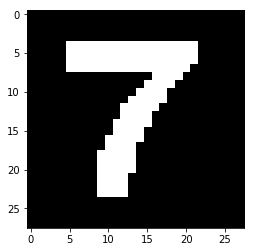

In [34]:
im = Image.open("9.jpg")
print(predict(im))

In [ ]:
app = Flask(__name__)

In [ ]:
@app.route('/predict_digit', methods=['POST'])
def predict_digit():
    encoded = request.form['encoded']
    
    im = Image.open(BytesIO(base64.b64decode(encoded)))
            
    return str(predict(im))

In [ ]:
if __name__ == '__main__':
    run_simple('0.0.0.0', 9001, app)